In [1]:
%matplotlib inline

import numpy as np
import sys
import os
import matplotlib.pyplot as plt
import math
import pickle
import pandas as pd
import scipy.io
import time
import h5py

from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable

from numpy import linalg as LA
from scipy.spatial import Delaunay
from sklearn.neighbors import NearestNeighbors

#sys.path.insert(0, "../")
from info3d import *
from nn_matchers import *

# EXTRACTING the existing sample data

In [2]:
with open('point_collection/new_contiguous_point_collection.pickle','rb') as f: 
    new_contiguous_point_collection = pickle.load(f)
    
with open('descriptors/new_complete_res5_4by5_descriptors.pickle','rb') as f:
    descriptors = pickle.load(f)


In [3]:
"""
Parameters
"""
# We used a radius range of 0.25 to 5.0 in increments of 0.25
radius_range = np.arange(0.5,1.6,0.5)

# Step 1: Results of partial spaces

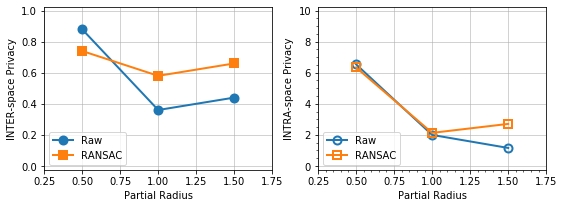

In [4]:
fig=plt.figure(figsize=(9, 3))

RawNN = []
RansacGeneralizedNN = []

RawNN_intra_errors = []
RansacGeneralizedNN_intra_errors = []

for radius in radius_range:
    
    try:
        with open('testing_results/partials/radius_{}_RAW_errors.pickle'.format(radius), 'rb') as f:
            partial_errors = pickle.load(f)

        RawNN.append([
            radius,
            np.mean(partial_errors[:,1]),
            np.std(partial_errors[:,1]),
        ])
        
        correct_interspace_labels_idxs = np.where(partial_errors[:,1]==0)[0]

        intraspace_errors  = partial_errors[correct_interspace_labels_idxs,2]

        RawNN_intra_errors.append([
            radius,
            np.nanmean(intraspace_errors),
            np.nanstd(intraspace_errors)
        ])
        
    except:
        pass
    
    try:
        with open('testing_results/partials/radius_{}_RANSAC_errors.pickle'.format(radius), 'rb') as f:
            partial_errors = pickle.load(f)

        RansacGeneralizedNN.append([
            radius,
            np.nanmean(partial_errors[:,1]),
            np.nanstd(partial_errors[:,1]),
        ])

        correct_interspace_labels_idxs = np.where(partial_errors[:,1]==0)[0]

        intraspace_errors  = partial_errors[correct_interspace_labels_idxs,2]

        RansacGeneralizedNN_intra_errors.append([
            radius,
            np.nanmean(intraspace_errors),
            np.nanstd(intraspace_errors)
        ])
        
    except:
        pass
    
RansacGeneralizedNN = np.asarray(RansacGeneralizedNN)
RawNN = np.asarray(RawNN)

RawNN_intra_errors = np.asarray(RawNN_intra_errors)
RansacGeneralizedNN_intra_errors = np.asarray(RansacGeneralizedNN_intra_errors)

ax1 = fig.add_subplot(121) 

ax1.grid(alpha = 0.7)
ax1.set_ylim(-0.025,1.025)
ax1.set_xlim(radius_range[0]-0.25,radius_range[-1]+0.25)
markersize = 8

ax1.set_ylabel("INTER-space Privacy")
ax1.set_xlabel("Partial Radius")
#ax1.set_yticklabels(fontsize = 16)
#ax1.set_xticklabels(fontsize = 16)

ax1.plot(
    RawNN[:,0],RawNN[:,1],
    "-o",
    linewidth = 2,
    mew = 2,markersize = markersize,
    label = "Raw"
)
ax1.plot(
    RansacGeneralizedNN[:,0],RansacGeneralizedNN[:,1],
    "-s",
    linewidth = 2,
    mew = 2,markersize = markersize,
    label = "RANSAC"
)

ax1.legend(loc = "lower left")

ax2 = fig.add_subplot(122) 

ax2.grid(alpha = 0.7)
ax2.set_ylim(-0.25,10.25)
ax2.set_xlim(radius_range[0]-0.25,radius_range[-1]+0.25)

ax2.set_ylabel("INTRA-space Privacy")
ax2.set_xlabel("Partial Radius")
#ax2.set_yticklabels(fontsize = 16)
#ax2.set_xticklabels(fontsize = 16)

plt.minorticks_on()

ax2.plot(
    RawNN_intra_errors[:,0],
    RawNN_intra_errors[:,1], 
    linewidth = 2,
    marker = 'o',fillstyle = 'none',
    mew = 2,markersize = markersize,
    label = "Raw"
)

ax2.plot(
    RansacGeneralizedNN_intra_errors[:,0],
    RansacGeneralizedNN_intra_errors[:,1], 
    linewidth = 2, 
    marker = 's',fillstyle = 'none',
    mew = 2,markersize = markersize,
    label = "RANSAC"
)

ax2.legend(loc = "lower left");

# Step 2: Results of the successive case

In [5]:
"""
Parameters
"""
# We used a radius range of 0.25 to 5.0 in increments of 0.25.
radius_range = radius_range

# For our work, we orignally used 50 samples with further 100 successive releases for our investigation.
# Below are lower parameters, change as desired.
samples = 50
releases = 50

# For demonstration purposes, we skip testing some successive samples but we still accumulate them.
skip = 3

In [14]:
succ_RawNN_errors = []
succ_RawNN_partial_errors = []

succ_RansacGeneralizedNN_errors = []
succ_RansacGeneralizedNN_partial_errors = []

t0 = time.time()

for radius in radius_range:
    
    succ_RawNN_per_iteration_errors = []
    succ_RansacGeneralizedNN_per_iteration_errors = []

    try:
                
        with open('testing_results/successive/radius_{}_RAW_successive_scores.pickle'.format(radius), 'rb') as f:
            successive_scores = pickle.load(f)

        with open('testing_results/successive/radius_{}_RAW_successive_errors.pickle'.format(radius), 'rb') as f:
            successive_errors = pickle.load(f)
        
        for obj_, iteration_errors in successive_errors:    
            #print("  RAW",radius,iteration_errors.shape)

            if iteration_errors.shape[0] < int(releases/skip):
                continue
            else:
                succ_RawNN_per_iteration_errors.append(iteration_errors[:int(releases/skip)])
       
        succ_RawNN_errors.append([
            radius,
            np.asarray(succ_RawNN_per_iteration_errors)
        ])
        
        #print(np.asarray(succ_RawNN_per_iteration_errors).shape)

    except:# Exception as ex:
        #print(radius,": successive RawNN\n  ", ex)
        pass
    
    try:
                
        with open('testing_results/successive/radius_{}_RANSAC_successive_scores.pickle'.format(radius), 'rb') as f:
            successive_scores = pickle.load(f)

        with open('testing_results/successive/radius_{}_RANSAC_successive_errors.pickle'.format(radius), 'rb') as f:
            successive_errors = pickle.load(f)
        
        for obj_, iteration_scores in successive_scores:#[:-1]:    
            #print("  RANSAC",radius,iteration_errors.shape)
            iteration_errors = NN_matcher(iteration_scores)

            if iteration_errors.shape[0] < int(releases/skip):
                continue
            else:
                succ_RansacGeneralizedNN_per_iteration_errors.append(iteration_errors[:int(releases/skip)])
       
        succ_RansacGeneralizedNN_errors.append([
            radius,
            np.asarray(succ_RansacGeneralizedNN_per_iteration_errors)
        ])
        
        #print(np.asarray(succ_RansacGeneralizedNN_errors).shape)

    except:# Exception as ex:
        #print(radius,": successive RansacNN\n  ", ex)
        pass
    
    print("Done with radius = {:.2f} in {:.3f} seconds".format(radius,time.time() - t0))
    t0 = time.time()
    
for radius, per_iteration_errors in succ_RawNN_errors:

    #print(per_iteration_errors.shape)

    succ_RawNN_partial_errors_per_rel = []

    for rel_i in np.arange(per_iteration_errors.shape[1]):

        correct_interspace_labels_idxs = np.where(per_iteration_errors[:,rel_i,1]==0)[0]

        intraspace_errors  = per_iteration_errors[correct_interspace_labels_idxs,rel_i,2]

        succ_RawNN_partial_errors_per_rel.append([
            rel_i,
            np.mean(intraspace_errors),
            np.std(intraspace_errors)
        ])

    succ_RawNN_partial_errors.append([
        radius,
        np.asarray(succ_RawNN_partial_errors_per_rel)
    ])
    
for radius, per_iteration_errors in succ_RansacGeneralizedNN_errors:

    #print(radius,per_iteration_errors.shape)

    succ_RansacGeneralizedNN_errors_per_rel = []

    for rel_i in np.arange(per_iteration_errors.shape[1]):

        correct_interspace_labels_idxs = np.where(per_iteration_errors[:,rel_i,1]==0)[0]

        intraspace_errors  = per_iteration_errors[correct_interspace_labels_idxs,rel_i,2]

        succ_RansacGeneralizedNN_errors_per_rel.append([
            rel_i,
            np.mean(intraspace_errors),
            np.std(intraspace_errors)
        ])

    succ_RansacGeneralizedNN_partial_errors.append([
        radius,
        np.asarray(succ_RansacGeneralizedNN_errors_per_rel)
    ])

Done with radius = 0.50 in 1.330 seconds
Done with radius = 1.00 in 3.891 seconds
Done with radius = 1.50 in 0.000 seconds


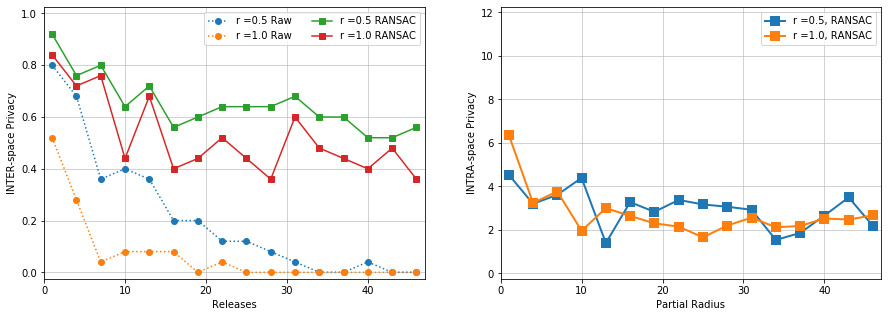

In [15]:
fig=plt.figure(figsize=(15, 5))

ax1 = fig.add_subplot(121) 

ax1.grid(alpha = 0.7)
ax1.set_ylim(-0.025,1.025)
ax1.set_xlim(0,releases-skip)
markersize = 8

ax1.set_ylabel("INTER-space Privacy")
ax1.set_xlabel("Releases")

for radius, RawNN_per_iteration_errors in succ_RawNN_errors:
    #print(RawNN_per_iteration_errors.shape)
    ax1.plot(
        np.arange(1,releases-skip,skip),#[:RawNN_per_iteration_errors.shape[1]],
        np.mean(RawNN_per_iteration_errors[:,:,1], axis = 0), 
        ':o',
        label = "r ="+ str(radius) + " Raw"
    )
    
for radius, RansacNN_per_iteration_errors in succ_RansacGeneralizedNN_errors:
    #print(RansacNN_per_iteration_errors.shape)
    ax1.plot(
        np.arange(1,releases-skip,skip),
        np.mean(RansacNN_per_iteration_errors[:,:,1], axis = 0),
        '-s',
        label = "r ="+ str(radius) + " RANSAC"
    )

ax1.legend(loc = "best", ncol = 2)

ax2 = fig.add_subplot(122) 

ax2.grid(alpha = 0.7)
ax2.set_ylim(-0.25,12.25)
ax2.set_xlim(0,releases-skip)

ax2.set_ylabel("INTRA-space Privacy")
ax2.set_xlabel("Partial Radius")
#ax2.set_yticklabels(fontsize = 16)
#ax2.set_xticklabels(fontsize = 16)

#plt.minorticks_on()

for radius, errors_per_rel in succ_RansacGeneralizedNN_partial_errors:
    ax2.plot(
        np.arange(1,releases-skip,skip),
        errors_per_rel[:,1], 
        #errors_per_rel[:,2],
        '-s',
        linewidth = 2, #capsize = 4.0, 
        #marker = markers[0],
        #fillstyle = 'none',
        mew = 2, markersize = markersize,
        label = "r ="+ str(radius)+", RANSAC"
    )

ax2.legend(loc = "best");

# Step 3: Results with conservative plane releasing

In [28]:
"""
Parameters:

Also, we use the same successive samples from successive releasing for direct comparability of results.
"""

# We used a radius range of 0.25 to 5.0 in increments of 0.25.
radius_range = radius_range

# For our work, we orignally used 50 samples with further 100 successive releases for our investigation.
# Below are lower parameters, change as desired.
samples = 50
releases = 50

planes = np.arange(1,30,3)

# For demonstration purposes, we skip testing some successive samples but we still accumulate them.
skip = 3

In [29]:
conservative_RANSAC_error_results = []

t0 = time.time()

for radius in radius_range:
    
    succ_RansacGeneralizedNN_per_iteration_errors = []
    
    try:
                
        with open('testing_results/conservative/radius_{}_RANSAC_conservative_scores.pickle'.format(radius), 'rb') as f:
            conservative_scores = pickle.load(f)

        with open('testing_results/conservative/radius_{}_RANSAC_conservative_errors.pickle'.format(radius), 'rb') as f:
            conservative_errors = pickle.load(f)
        
        for obj_, per_plane_scores in conservative_scores:#[:-1]:  
            
            per_plane_errors = []
            
            skipped= False
            
            for max_plane, iteration_scores in per_plane_scores:
                
                iteration_errors = NN_matcher(iteration_scores)
                
                if iteration_errors.shape[0] >= int(releases/skip):
                    per_plane_errors.append(iteration_errors[:int(releases/skip)])
                else:
                    skipped = True
                    #print("RANSAC: skipped",iteration_errors.shape)
                    
            if not skipped:
                succ_RansacGeneralizedNN_per_iteration_errors.append(per_plane_errors)
       
        conservative_RANSAC_error_results.append([
            radius,
            np.asarray(succ_RansacGeneralizedNN_per_iteration_errors)
        ])
        
        print(np.asarray(succ_RansacGeneralizedNN_per_iteration_errors).shape)
              
    except Exception as ex:
        print(radius,": conservative RansacNN\n  ", ex)
        pass
    
    
    print("Done with radius = {:.2f} in {:.3f} seconds".format(radius,time.time() - t0))
    t0 = time.time()
    
"""
# Uncomment below if you want to overwrite the existing results.
"""
#with open('testing_results/conservative/conservative_RANSAC_error_results.pickle', 'wb') as f:
#    pickle.dump(conservative_RANSAC_error_results,f)

0.5 : conservative RansacNN
   invalid load key, 'v'.
Done with radius = 0.50 in 0.001 seconds
1.0 : conservative RansacNN
   [Errno 2] No such file or directory: 'testing_results/conservative/radius_1.0_RANSAC_conservative_scores.pickle'
Done with radius = 1.00 in 0.000 seconds
1.5 : conservative RansacNN
   [Errno 2] No such file or directory: 'testing_results/conservative/radius_1.5_RANSAC_conservative_scores.pickle'
Done with radius = 1.50 in 0.000 seconds


'\n# Uncomment below if you want to overwrite the existing results.\n'

In [23]:
"""

Preparing the results of the case with *Conservative Releasing*.

"""

releases_range = np.arange(1,releases-skip,skip)

X, Y = np.meshgrid(releases_range, planes)

test_vp_cn_05 = np.asarray(conservative_RANSAC_error_results[0][1])
mean_vp_cn_05 = np.mean(test_vp_cn_05[:,:,:,1],axis = 0)

#test_vp_cn_10 = np.asarray(conservative_RANSAC_error_results[1][1])
#mean_vp_cn_10 = np.mean(test_vp_cn_10[:,:,:,1],axis = 0)

intra_vp_cn_05 = np.zeros(test_vp_cn_05.shape[1:])
#intra_vp_cn_10 = np.zeros(test_vp_cn_10.shape[1:])

for plane_i, plane in enumerate(planes):
        
    for rel_i, rel in enumerate(releases_range):
    
        correct_interspace_labels_idxs_05 = np.where(test_vp_cn_05[:,plane_i,rel_i,1]==0)[0]
        #correct_interspace_labels_idxs_10 = np.where(test_vp_cn_10[:,plane_i,rel_i,1]==0)[0]

        intraspace_errors_05  = test_vp_cn_05[correct_interspace_labels_idxs_05,plane_i,rel_i,2]
        #intraspace_errors_10  = test_vp_cn_10[correct_interspace_labels_idxs_10,plane_i,rel_i,2]
        
        intra_vp_cn_05[plane_i,rel_i] = np.asarray([
            np.mean(intraspace_errors_05),
            np.std(intraspace_errors_05),
            0,
            np.nan
        ])
        

/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/_methods.py:110: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/jaybie/.conda/envs/3d_env/lib/python3.7/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


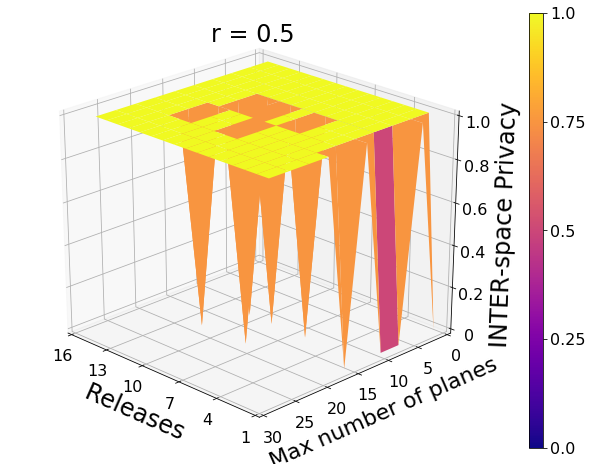

In [26]:
fig = plt.figure(figsize=(11,8))
ax = plt.axes(projection='3d')

surf = ax.plot_surface(
    X, Y, 
    mean_vp_cn_05, 
    cmap=plt.cm.plasma,
)
surf.set_clim(0.0,1.0)

ax.set_title("r = 0.5", fontsize = 24)
ax.set_xlabel("Releases", labelpad=10, fontsize = 24)
ax.set_xlim(0,releases)
ax.set_xticklabels(releases_range,fontsize = 16)
ax.set_zlabel("INTER-space Privacy", labelpad=10, fontsize = 24)
ax.set_zlim(0,1)
ax.set_zticklabels([0,0.2,0.4,0.6,0.8,1.0],fontsize = 16)
ax.set_ylabel("Max number of planes", labelpad=10, fontsize = 22)#, offset = 1)
ax.set_ylim(0,30)
ax.set_yticklabels(np.arange(0,35,5),fontsize = 16)

cbar = fig.colorbar(surf, aspect=30, ticks = np.arange(0.0,1.1,0.25))
cbar.ax.set_yticklabels(np.arange(0.0,1.1,0.25),fontsize = 16)

ax.view_init(25,135);